# Recommending movies using Cosine similarity

The aim of this experiment is to build a cosine similarity model and recommend movies by predicting the movie rating using the model.

Cosine similarity is preferred to any other measure of similarity because of the way 0's are treated. In the rating data, missing values are represented by 0. Cosine similarity, being based on dot product nullifies the effect of 0's. Thus, 0 is treated as a missing value instead of a rating lower than 1 (which could have been the case in for example euclidean distance)

In [3]:
import pandas as pd

movies = pd.read_csv("../data/intermediate/movies.csv", index_col=0)

movies.head()

,MovieID,Title,Genres,ContinuousMovieID
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [4]:
import scipy.io

R = scipy.io.mmread("../data/intermediate/user_movie_ratings.mtx").tocsr()


print ('{0}x{1} user by movie matrix'.format(*R.shape))

6040x3883 user by movie matrix


## Computing cosine similarity

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(R.T)
print (similarities.shape)

(3883, 3883)


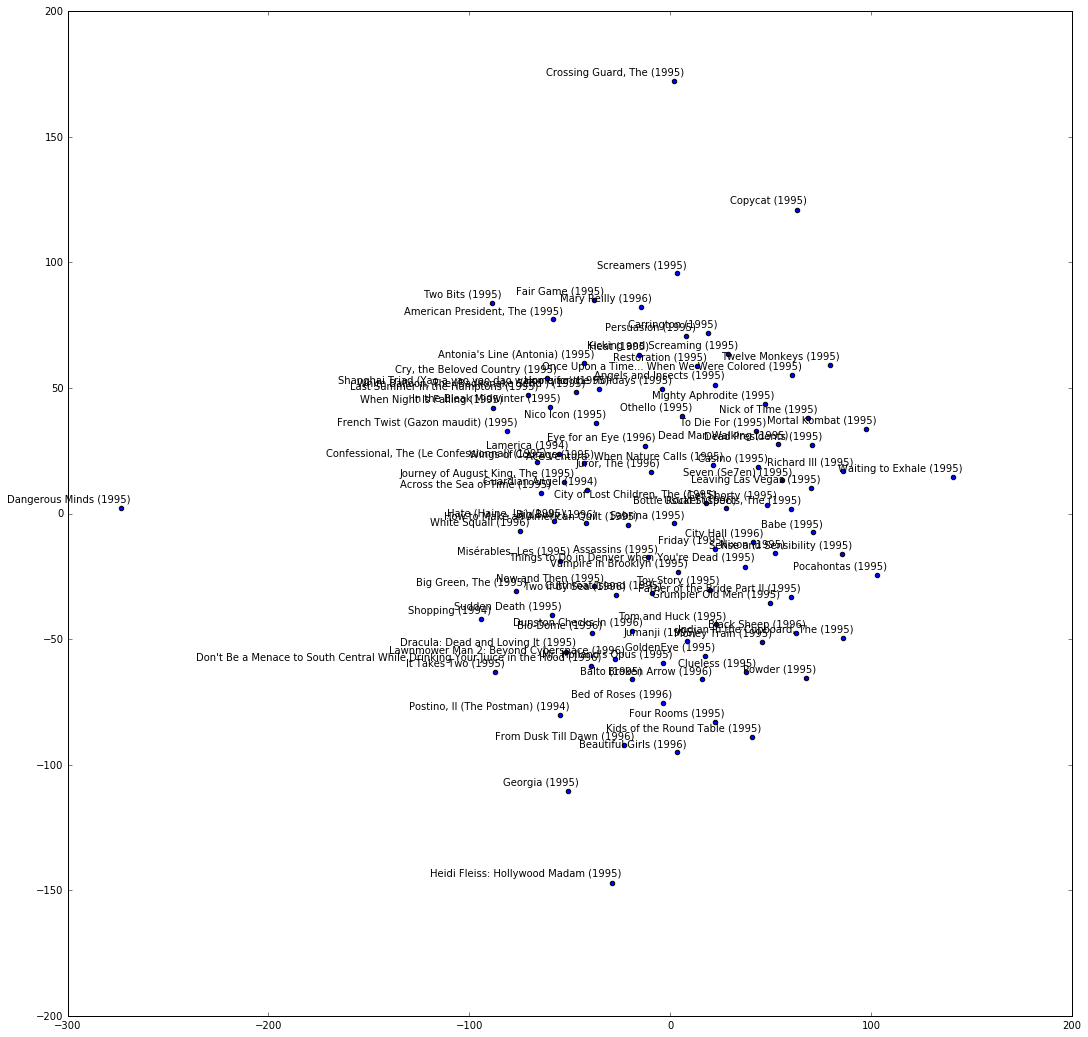

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

tsne = TSNE(perplexity=15, n_components=2, init="pca", n_iter=5000)
plot_only = 100
coords = tsne.fit_transform(similarities[:plot_only, :])

plt.figure(figsize=(18, 18))
labels = [movies.iloc[i].Title.decode("latin_1") for i in range(plot_only)]
for i, label in enumerate(labels):
    x, y = coords[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(10, 4),
                 textcoords="offset points",
                 ha="right",
                 va="bottom")

plt.show()


In [18]:
def similar_movies(model, movie_id, n=5):
    return model[movie_id].argsort()[::-1][:n].tolist()

In [20]:
movies.iloc[similar_movies(similarities, 4)]

,MovieID,Title,Genres,ContinuousMovieID
4,5,Father of the Bride Part II (1995),Comedy,4
582,586,Home Alone (1990),Children's|Comedy,582
2884,2953,Home Alone 2: Lost in New York (1992),Children's|Comedy,2884
2013,2082,"Mighty Ducks, The (1992)",Children's|Comedy,2013
496,500,Mrs. Doubtfire (1993),Comedy,496


## Predicting Ratings

A rating $r_um$ for movie $m$ by user $u$ is given by taking an average of n - similar movies that have been
rated by the current user weighted by their similarity to the current movie.

$$ r_{um} = \frac{ \sum_{i=1}^{n} r_{ui} \cdot s_{mi} } { \sum_{i=1}^{n} s_{mi} } $$

where $s_{mi}$ is the similarity between movies $m$ and $i$.

In [78]:
import numpy as np

def predict_rating(model, ratings, movie_id, n=5):
    #
    # model = movie similarities matrix
    # movie_id = target movie id
    # ratings = dict of movie_id: rating
    # 
    
    rated_movies = ratings.keys()
    similar_movies = model[movie_id, rated_movies].argsort()[::-1]
    top_n = [ratings.keys()[i] for i in similar_movies[:n]]
    
    # Average rating weighted by similarity
    scores = sum(model[movie_id, m] * ratings[m] for m in top_n)
    
    prediction = float(scores) / sum(model[movie_id, m] for m in top_n)
    return prediction
    


In [83]:
user_id = 10
movies_rated = np.where(R[user_id].todense() > 0)[1].tolist()
movie_ratings = R[user_id, movies_rated].todense().tolist()[0]

user_ratings = dict(zip(movies_rated, movie_ratings))

for movie_id in [10, 100, 1000]:
    print movie_id, predict_rating(similarities, user_ratings, movie_id)

10 2.77208508312
100 1.77135318293
1000 2.35262213947
